In [1]:
# GET PARAMETERS
import os 
import sys
import itertools
import numpy as np 
import pandas as pd
from argparse import Namespace
# Get Parent folder : 
current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path, '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)


from load_inputs.Lyon.pt.subway_in import load_data as load_data_subway_in,START, END,FILE_NAME
from pipeline.plotting.TS_analysis import plot_TS,plot_line_and_buffer

from examples.benchmark import local_get_args
from constants.paths import FOLDER_PATH
from examples.train_and_visu_non_recurrent import get_ds
from examples.train_model_on_k_fold_validation import load_configuration
from pipeline.plotting.plot_distribution_inputs import plot_scatter_distribution_by_calendar_group,plot_distribution_by_calendar_group,get_usefull_params
from pipeline.calendar_class import  get_temporal_mask
import datetime


def filter_df_by_temporal_agg(ds_in,df_in,s_dates,temporal_agg,start_morning_peak = datetime.time(7,30), end_morning_peak = datetime.time(9,0),start_evening_peak = datetime.time(17,0), end_evening_peak = datetime.time(19,0)):
    date_mask = get_temporal_mask(s_dates,start = datetime.time(0, 0),end = datetime.time(23, 45), temporal_agg= temporal_agg , city = ds_in.city,
                                  start_morning_peak=start_morning_peak,end_morning_peak=end_morning_peak,
                                  start_evening_peak=start_evening_peak,end_evening_peak=end_evening_peak)
    df_date_mask = pd.DataFrame(s_dates[date_mask]).set_index('t-1')
    df_date_mask['keep'] = True
    df_date_mask = df_date_mask.reindex(df_in.index).fillna(False)
    filtered_df = df_in[df_date_mask['keep']]
    return filtered_df

def get_daily_profile(ds_in,df_in,s_dates,temporal_agg,
                      start_morning_peak = datetime.time(7,30), end_morning_peak = datetime.time(9,0),start_evening_peak = datetime.time(17,0), end_evening_peak = datetime.time(19,0)):
    """
    Get the daily profile (mean, median, std) for a given temporal aggregation.
    Parameters:
    - ds_in: The dataset object containing the data and metadata.
    - df_in: The input DataFrame with time series data.
    - s_dates: Series of dates corresponding to the DataFrame index.
    - temporal_agg: The temporal aggregation type: ['morning_peak', 'evening_peak', 'off_peak', 'bank_holiday', 'business_day', 'morning', 'evening'].
    """
    filtered_df = filter_df_by_temporal_agg(ds_in,df_in,s_dates,temporal_agg,start_morning_peak,end_morning_peak,start_evening_peak,end_evening_peak)

    # ----- 
    filtered_df['time'] = filtered_df.index.time
    mean_df = filtered_df.groupby(['time']).mean()
    std_df = filtered_df.groupby(['time']).std()
    median_df = filtered_df.groupby(['time']).median()   
    return filtered_df,mean_df, median_df,std_df    


/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


No module xgboost
Training and Hyper-parameter tuning with Ray is not possible


In [2]:
invalid_dates = []
minmaxnorm = True
standardize = False  # Set to True if you want to standardize the data
config = {'model_name': 'STGCN',
         'freq' : '15min',
        'dataset_names':['subway_in'],
        'dataset_for_coverage' : ['subway_in'],
        'target_data': 'subway_in',
        'contextual_kwargs':{'subway_in':{},
                           },
        'target_kwargs':{'subway_in':{'quantile_filter_outliers':0.99}},
        'step_ahead':1,
        'horizon_step':1,
        }

args = local_get_args(config['model_name'],
                args_init = None,
                dataset_names=config['dataset_names'],
                dataset_for_coverage=config['dataset_for_coverage'],
                modification = config)



coverage_period = pd.date_range(start=START, end=END, freq='15min')[:-1]  # Exclude the last date to match the data
args_out = Namespace(**vars(args))  
args_out.target_data = 'subway_in'
args_out.dataset_for_coverage = ['subway_in']
args_out.dataset_names = ['subway_in']
args_out.contextual_kwargs = {}


ds_in = load_data_subway_in(FOLDER_PATH, coverage_period=coverage_period, invalid_dates=invalid_dates, args=args_out, minmaxnorm=minmaxnorm,standardize=standardize, normalize=True,filename=FILE_NAME,
              tensor_limits_keeper = None)
df_in =  pd.DataFrame(ds_in.U_train[:,:,-1].detach().cpu().numpy(),columns = ds_in.spatial_unit, index = ds_in.tensor_limits_keeper.df_verif_train.iloc[:,-2] )

   Load data from: //home/rrochas/../../data/rrochas/prediction_validation/subway_in/subway_in.csv


## Plot Distribution of the Training Set 
- Le training set peut contenir de la Data Augmentation si le Trial considéré en à utilisé un. 
    - 'subway_in_STGCN_MSELoss_2025_01_06_08_00_94523' à par exemple les mardi et jeudi 23h-00h augmenté par interpolation (x2)
- 'agg' choisi le type d'aggreagtion temporelle. Si on aggrègre pas du tout, ou si on aggrègre par heure.
- station_ind parcours les stations qui nous intéresse. Il y a 40 stations, donc théoriquement on pourrait faire : 
    - for station_ind in np.arange(len(ds.spatial_unit)): 

In [3]:

s_dates = ds_in.tensor_limits_keeper.df_verif_train.iloc[:,-2]


# 'morning_peak', 'evening_peak', 'off_peak', 'bank_holiday', 'business_day', 'morning', 'evening'

# laneA =  ['PER','AMP','BEL', 'COR','HOT','FOC', 'MAS', 'CHA', 'REP','GRA','FLA','CUS', 'BON', 'SOI']
# laneB = ['CHA','BRO','PAR','GUI', 'SAX',  'MAC', 'JAU','DEB', 'GER','OGA' ]
# laneC = ['CUI', 'HEN','CRO','CPA','HOT']
# laneD = ['VAI','VMY','GOR','FOU', 'JEA','BEL',  'GIL',  'SAX','GAR','SAN', 'LUM','BLA', 'LAE', 'MER', 'PRY','VEN']
   

# Pinks/Reds	pink, lightpink, mistyrose, lightcoral, peachpuff
# Purples/Violets	thistle, plum, lavender, orchid, violet
# Blues/Cyans	powderblue, lightblue, lightskyblue, paleturquoise, azure, lightcyan
# Greens	palegreen, lightgreen, honeydew, mintcream, aquamarine
# Yellows/Oranges	lightyellow, lemonchiffon, cornsilk, papayawhip, moccasin
# Neutrals	whitesmoke, gainsboro, linen, seashell


# Evening Activity : PAR GER   'blue'  
# Morning Residential : REP   # 'red'
filtered_df,mean_df, median_df,std_df = get_daily_profile(ds_in,df_in,s_dates,temporal_agg = 'business_day')
for df in [mean_df, median_df, std_df]:
    df.columns = [f"{c} Business Day" for c in df.columns]

filtered_df,n_mean_df, n_median_df,n_std_df = get_daily_profile(ds_in,df_in,s_dates,temporal_agg = 'bank_holiday')
for df in [n_mean_df, n_median_df, n_std_df]:
    df.columns = [f"{c} Non Business Day" for c in df.columns]

mean_df = pd.concat([mean_df,n_mean_df], axis=1)
median_df = pd.concat([median_df,n_median_df], axis=1)
std_df = pd.concat([std_df,n_std_df], axis=1)

colors = ['blue','blue','red','red','red']
columns = ['PAR','GER','REP','BEL','AMP']

# columns = [f"{c} Business Day" for c in columns] + [f"{c} Non Business Day" for c in columns]
# colors = colors+colors
# plot_line_and_buffer(mean_df, median_df,std_df, title = 'Subway-Inflow daily profil (normalized) according to day type',colors=colors, columns =columns,width=800,height=400)

for k,c in enumerate(columns):
    columns_i =  [f"{c} Business Day" ,f"{c} Non Business Day"]
    if colors[k] == 'blue':
        colors_i = ['midnightblue','cadetblue']  # 'darkcyan' # 'plum'
    else:
        colors_i = ['indianred','peru']  # indianred # 'lightcoral','peachpuff' # darkred
    mean_df_i = mean_df[columns_i]
    median_df_i = median_df[columns_i]
    std_df_i = std_df[columns_i]
    plot_line_and_buffer(mean_df_i, median_df_i,std_df_i, title = f'Subway-Inflow daily profil (normalized) at station {c}',
                         colors=colors_i, columns =columns_i,width=600,height=500,legend_str = ['Business Day','Non Business Day'])





/tmp/ipykernel_182556/747528886.py:33: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_date_mask = df_date_mask.reindex(df_in.index).fillna(False)
/tmp/ipykernel_182556/747528886.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['time'] = filtered_df.index.time
/tmp/ipykernel_182556/747528886.py:33: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_o

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

/tmp/ipykernel_182556/747528886.py:33: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_date_mask = df_date_mask.reindex(df_in.index).fillna(False)
/tmp/ipykernel_182556/747528886.py:33: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_date_mask = df_date_mask.reindex(df_in.index).fillna(False)


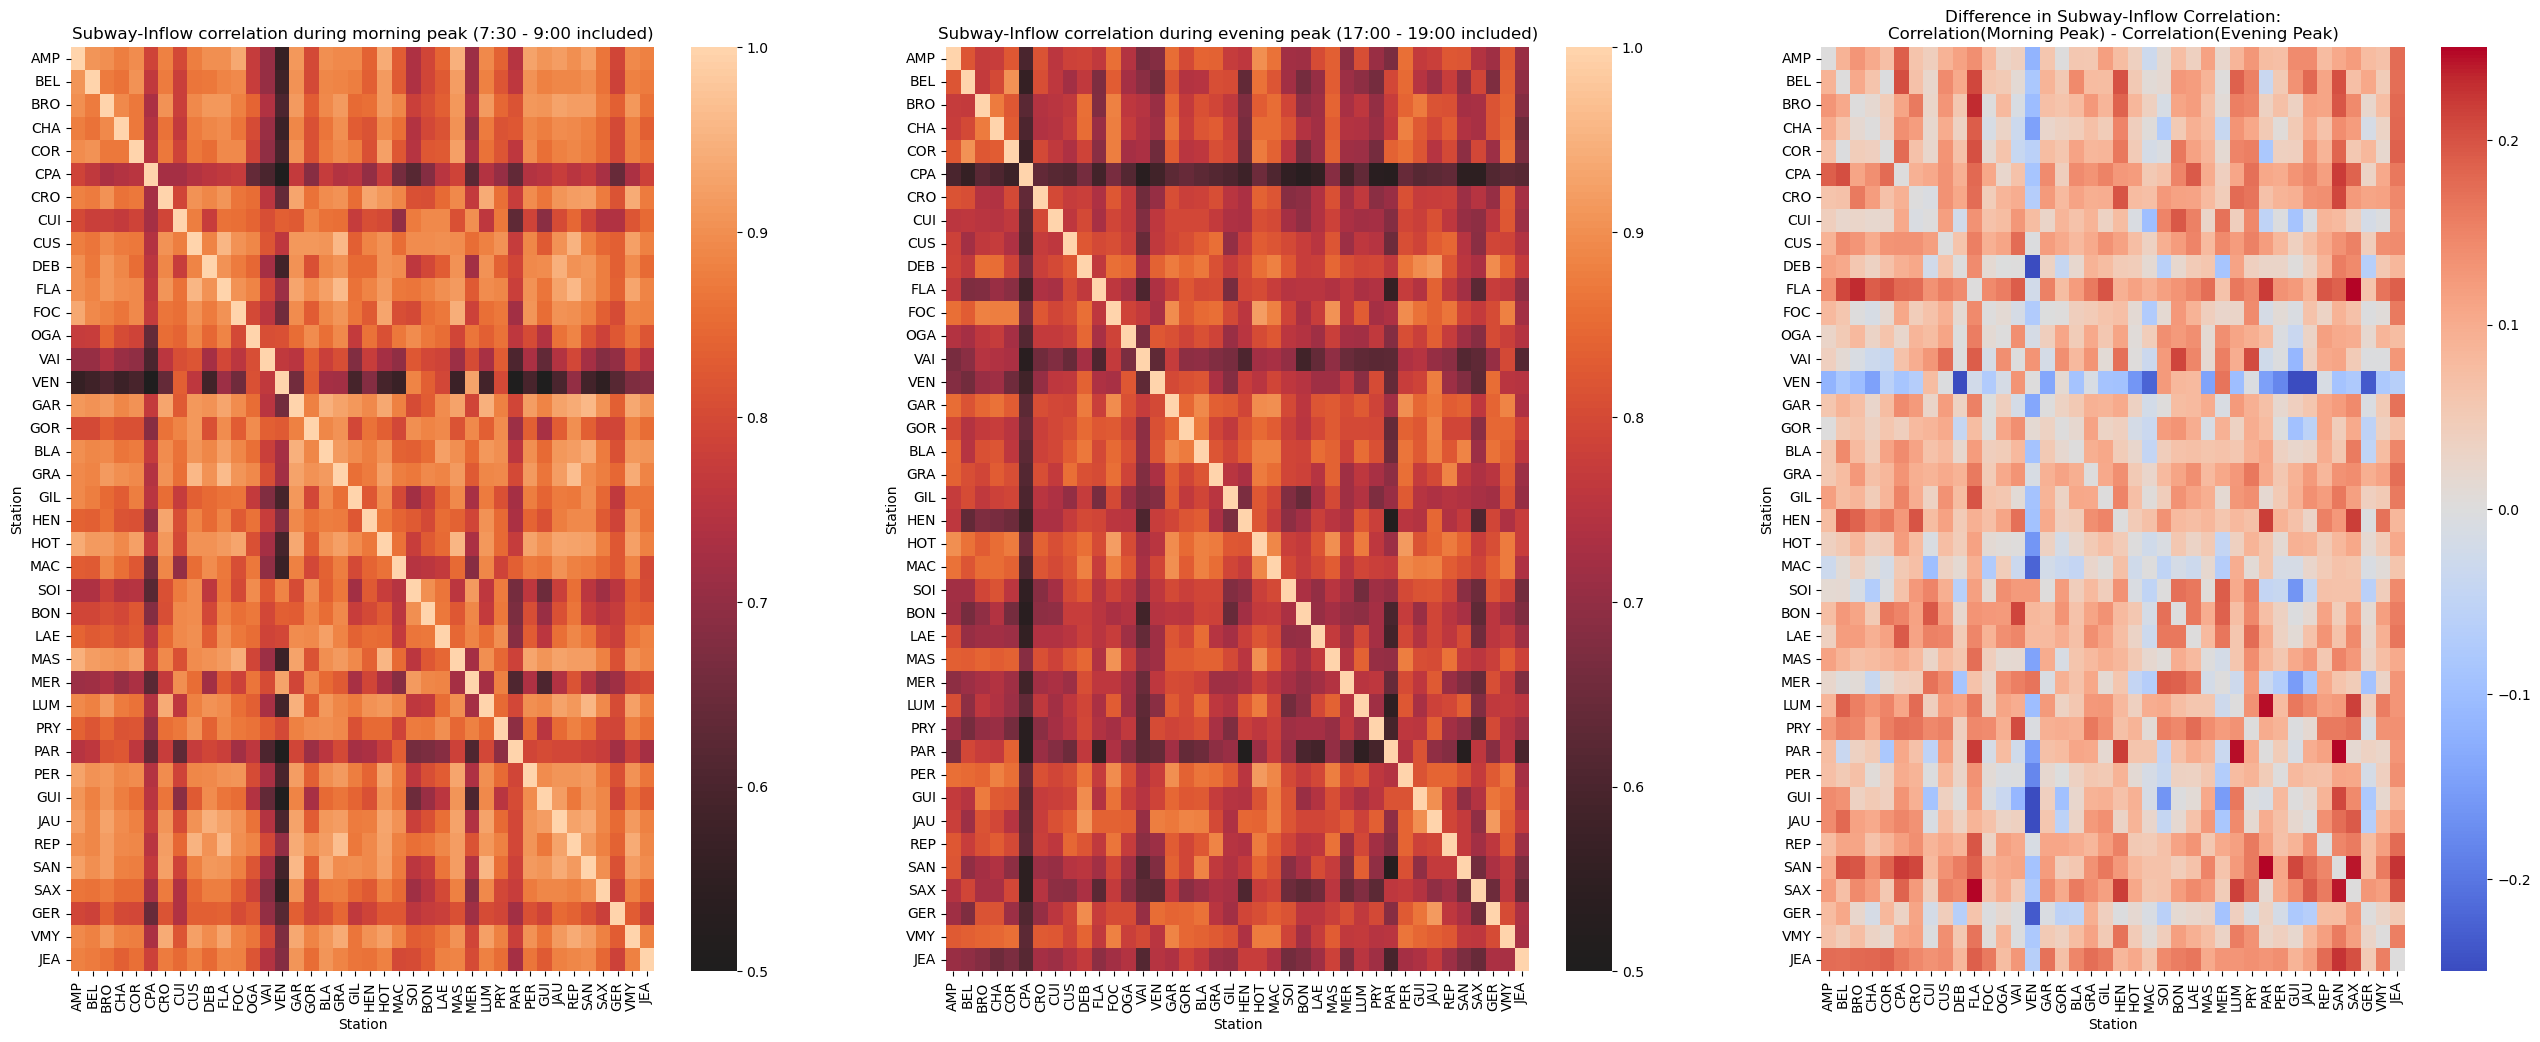

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

# Morning Peak Correlation
temporal_agg = 'morning_peak'
df_in_morning = filter_df_by_temporal_agg(ds_in,df_in,s_dates,temporal_agg,start_morning_peak = datetime.time(7,30), end_morning_peak = datetime.time(9,0))
corr_morning = df_in_morning.corr()
# Evening Peak Correlation : 
temporal_agg = 'evening_peak'
df_in_evening = filter_df_by_temporal_agg(ds_in,df_in,s_dates,temporal_agg,start_evening_peak = datetime.time(17,0), end_evening_peak = datetime.time(19,0))
corr_evening = df_in_evening.corr()

# # Full Day Correlation :
corr_diff = corr_morning - corr_evening

cmap = None
plt.figure(figsize=(32,12)) # figsize=(50,24)
ax = plt.subplot(1,3,1)
sns.heatmap(corr_morning,vmin= 0.5, vmax=1, center=0.5, cmap=cmap)#, annot=True, fmt=".2f")
ax.set_title(label = 'Subway-Inflow correlation during morning peak (7:30 - 9:00 included)')

ax = plt.subplot(1,3,2)
sns.heatmap(corr_evening,vmin= 0.5, vmax=1, center=0.5, cmap=cmap)#, annot=True, fmt=".2f")
ax.set_title(label = 'Subway-Inflow correlation during evening peak (17:00 - 19:00 included)')

ax = plt.subplot(1,3,3)
sns.heatmap(corr_diff,vmin= -0.25, vmax=0.25, center=0.0, cmap='coolwarm')# , annot=True, fmt=".2f") # , annot=True, fmt=".2f")
ax.set_title(label = 'Difference in Subway-Inflow Correlation:\nCorrelation(Morning Peak) - Correlation(Evening Peak)')
plt.show()

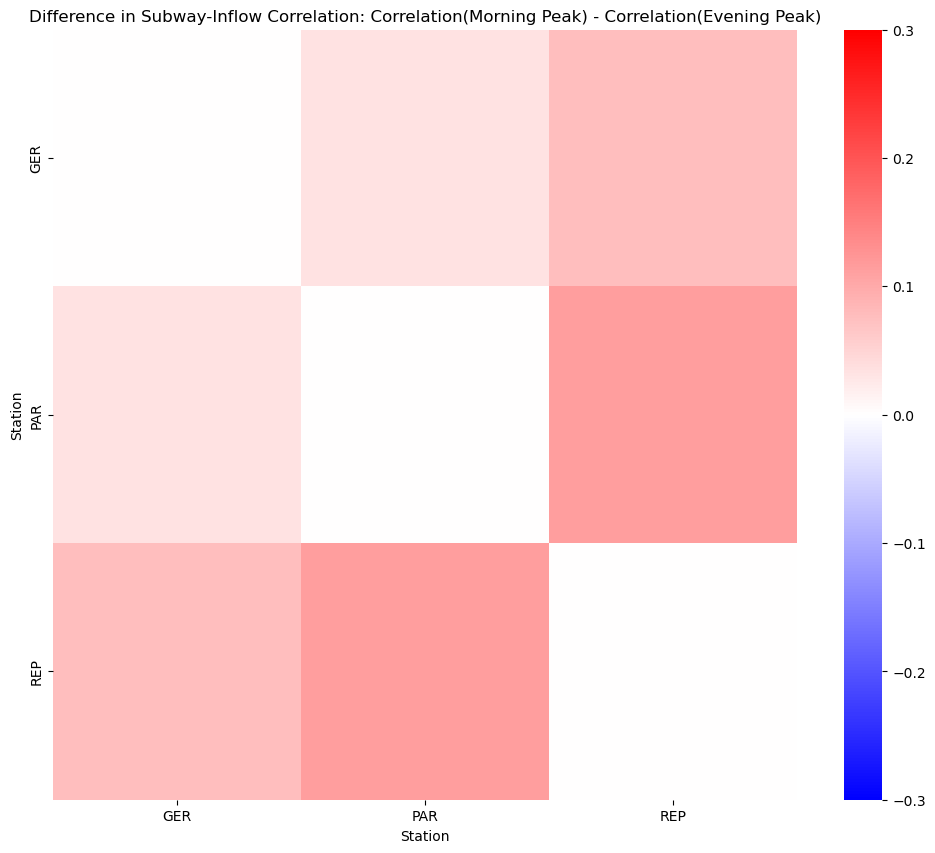

In [ ]:
#  Difference morning - evening correlation
stations = ['GER','PAR','REP']



In [ ]:


# Morning Peak Correlation
temporal_agg = 'morning_peak'
df_in_morning = filter_df_by_temporal_agg(ds_in,df_in,s_dates,temporal_agg,start_morning_peak = datetime.time(7,00), end_morning_peak = datetime.time(9,30))
corr_morning = df_in_morning.corr()
# Evening Peak Correlation : 
temporal_agg = 'evening_peak'
df_in_evening = filter_df_by_temporal_agg(ds_in,df_in,s_dates,temporal_agg,start_evening_peak = datetime.time(16,15), end_evening_peak = datetime.time(18,45))
corr_evening = df_in_evening.corr()

# # Full Day Correlation :
# corr_full = df_in.corr()

plt.figure(figsize=(24,10))
ax = plt.subplot(1,2,1)
sns.heatmap(corr_morning,vmin= 0.6, vmax=1, center=0.8, cmap='coolwarm')
ax.set_title(label = 'Subway-Inflow correlation during morning peak (7:00 - 9:30 included)')
ax = plt.subplot(1,2,2)
sns.heatmap(corr_evening,vmin= 0.6, vmax=1, center=0.8, cmap='coolwarm')
ax.set_title(label = 'Subway-Inflow correlation during evening peak (16:15 - 18:45 included)')
plt.show()

# Old :

In [ ]:



def preprocess_calendar_possibilities(ds,training_mode):
    t_minus_1 = getattr(ds.tensor_limits_keeper,f"df_verif_{training_mode}").iloc[:,-2].reset_index(drop=True)
    s_hours = t_minus_1.dt.hour
    s_weekdays = t_minus_1.dt.weekday
    s_minutes = t_minus_1.dt.minute

    posible_hours = s_hours.unique()
    posible_hours.sort()
    posible_weekdays = s_weekdays.unique()
    posible_weekdays.sort()
    posible_minutes = s_minutes.unique()
    posible_minutes.sort()
    return t_minus_1,s_hours,s_weekdays,s_minutes,posible_hours,posible_weekdays,posible_minutes
import numpy as np 


import torch.nn as nn
import torch
import sys
import os
# Get Parent folder : 
current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path, '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)


def plot_line_and_buffer(df_ts, df_buffer, title,width=800,height=400,x_datetime=True):
       if x_datetime:
             p = figure(x_axis_type="datetime",title=title,width=width,height=height)
       else: 
             p = figure(title=title,width=width,height=height)
       legend_it = []
       colors = palette

       nb_cols = len(df_ts.columns)
        for k,column in enumerate(df_ts.columns):
            c = p.line(x=df_ts.index, y=df_ts[column], alpha=0.8,color = colors[int(k*(255/nb_cols))])
            if df_buffer is not None:
                upper = df_ts[column] + df_buffer[column]
                lower = df_ts[column] - df_buffer[column]
                band = BoxAnnotation(bottom=lower, top=upper, fill_alpha=0.1, fill_color=colors[int(k*(255/nb_cols))], opacity=0.3)
                p.add_layout(band)
            displayed_legend = str(column)
            legend_it.append((displayed_legend, [c]))

       p.xaxis.major_label_orientation = 1.2  # Pour faire pivoter les labels des x
       legend = Legend(items=legend_it)
       legend.click_policy="hide"
       p.add_layout(legend, 'right')
       output_notebook()
       show(p)


line_median = np.array([np.median(x) if len(x) > 0 else 0 for x in list_of_point_to_plots])
buffer_std = np.array([np.std(x) if len(x) > 0 else 0 for x in list_of_point_to_plots])

line_median = pd.DataFrame(line_median, index = x_ticks, columns = ['median'])
buffer_std = pd.DataFrame(buffer_std, index = x_ticks, columns = ['std'])
plot_line_and_buffer(line_median, buffer_std, title,width=800,height=400,x_datetime=True)

array([0.0115425 , 0.00734523, 0.00314795, 0.        , 0.        ,
       0.        , 0.        , 0.13221405, 0.25603357, 0.37565583,
       0.58447009, 0.52885622, 0.48793283, 0.4616999 , 0.46065056,
       0.45120671, 0.30325288, 0.20461699, 0.20146905, 0.19832109,
       0.15844701, 0.13431269, 0.13746065, 0.14480588, 0.11437566,
       0.13431269, 0.12172088, 0.11962225, 0.11227702, 0.12591815,
       0.15739769, 0.13536201, 0.15005247, 0.17733473, 0.20041972,
       0.18887722, 0.18048269, 0.17418678, 0.16474292, 0.17628542,
       0.14270724, 0.16579224, 0.16894019, 0.16894019, 0.18258132,
       0.21825813, 0.2864638 , 0.25708291, 0.27282268, 0.30535153,
       0.35571879, 0.26967472, 0.28856245, 0.20776495, 0.22770199,
       0.16159496, 0.13116474, 0.10912906, 0.09653725, 0.0818468 ,
       0.08079748, 0.06295907, 0.06400839, 0.06190976, 0.04721931,
       0.03987408, 0.04407135, 0.03357817, 0.03252885, 0.0409234 ,
       0.03567681, 0.01993704, 0.01993704, 0.01888772, 0.01364

In [ ]:
concatenated.reshape(-1,)

(15724,)

In [25]:
for agg in [None]: # [None,'hour','weekday_hour']
    for training_mode in ['train']: # ['train','valid','test']
        print('training_mode: ',training_mode)
        t_minus_1,s_hours,s_weekdays,s_minutes,posible_hours,posible_weekdays,posible_minutes = preprocess_calendar_possibilities(ds_in,training_mode)
        for station in ['CHA','GER','GRA','OGA','PER','VEN']:
            station_ind = list(ds_in.spatial_unit).index(station)
            # Load data to plot
            add_to_point_to_plots,tuples,x_ticks = get_usefull_params(ds_in,t_minus_1,agg,posible_weekdays,posible_hours,posible_minutes,s_weekdays,s_hours,s_minutes,training_mode)
            list_of_point_to_plots = add_to_point_to_plots(tuples,station_ind)

            # plot 
            box_fig = plot_distribution_by_calendar_group(list_of_point_to_plots,x_ticks,ds_in.spatial_unit[station_ind])
            scatter_fig = plot_scatter_distribution_by_calendar_group(list_of_point_to_plots,x_ticks,ds_in.spatial_unit[station_ind],height=300, width=1300)
            # Afficher
            #show(column(scatter_fig, box_fig))
            #show(box_fig)
            output_notebook()
            show(scatter_fig)

training_mode:  train


Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...